<a href="https://colab.research.google.com/github/oikn2018/CS6910_assignment_3/blob/main/a3_wo_attn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Commands
! pip install wget
! pip install gdown
! pip install --upgrade gdown
# ! pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=e2a26c7a93dc76fe927bdc4ad71b52d1a39a359b54f0b97926cff51d18bd97f4
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 19.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import torch.optim as optim
from torch.autograd import Variable
import os
import gdown
import wandb
from io import open
import string, time, math
import wget
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from torch.utils.data import Dataset
import re

In [ ]:
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
# CUDA
torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic=True
# torch.backends.cudnn.benchmark=False

In [ ]:
device_gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Getting the Dataset
url = 'https://drive.google.com/uc?id=1uRKU4as2NlS9i8sdLRS1e326vQRdhvfw&export=download'
# filename = os.path.basename(url)
# print(filename)

if not os.path.exists("aksharantar_sampled"):
  filename = gdown.download(url = url, quiet=False, fuzzy=True)
  print(filename)
  with ZipFile(filename, 'r') as z:
    print('Extracting files...')
    z.extractall()
    print('Done!')
  os.remove(filename)

Downloading...
From: https://drive.google.com/uc?id=1uRKU4as2NlS9i8sdLRS1e326vQRdhvfw
To: /content/aksharantar_sampled.zip
100%|██████████| 14.0M/14.0M [00:00<00:00, 55.9MB/s]


aksharantar_sampled.zip
Extracting files...
Done!


In [ ]:
eng_alpha = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char = '<PAD>'

eng_alpha2idx = {pad_char: 0}
for index, alpha in enumerate(eng_alpha):
  eng_alpha2idx[alpha] = index+1

print(eng_alpha2idx)

{'<PAD>': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [ ]:
# Change Indic Language here
indic_lang = 'ben'
indic_lang = 'hin'

In [ ]:
# Bengali Unicode Hex Range: 2432-2558
# Hindi Unicode Hex Range: 2304-2431

min_range = 2304
max_range = 2431

if indic_lang == 'ben':
  min_range = 2432
  max_range = 2558
elif indic_lang == 'hindi':
  min_range = 2304
  max_range = 2431

indic_alpha = [chr(alpha) for alpha in range(min_range, max_range + 1)]
indic_alpha_size = len(indic_alpha)

indic_alpha2idx = {pad_char: 0}
for index, alpha in enumerate(indic_alpha):
  indic_alpha2idx[alpha] = index+1

print(indic_alpha2idx)

{'<PAD>': 0, 'ঀ': 1, 'ঁ': 2, 'ং': 3, 'ঃ': 4, '\u0984': 5, 'অ': 6, 'আ': 7, 'ই': 8, 'ঈ': 9, 'উ': 10, 'ঊ': 11, 'ঋ': 12, 'ঌ': 13, '\u098d': 14, '\u098e': 15, 'এ': 16, 'ঐ': 17, '\u0991': 18, '\u0992': 19, 'ও': 20, 'ঔ': 21, 'ক': 22, 'খ': 23, 'গ': 24, 'ঘ': 25, 'ঙ': 26, 'চ': 27, 'ছ': 28, 'জ': 29, 'ঝ': 30, 'ঞ': 31, 'ট': 32, 'ঠ': 33, 'ড': 34, 'ঢ': 35, 'ণ': 36, 'ত': 37, 'থ': 38, 'দ': 39, 'ধ': 40, 'ন': 41, '\u09a9': 42, 'প': 43, 'ফ': 44, 'ব': 45, 'ভ': 46, 'ম': 47, 'য': 48, 'র': 49, '\u09b1': 50, 'ল': 51, '\u09b3': 52, '\u09b4': 53, '\u09b5': 54, 'শ': 55, 'ষ': 56, 'স': 57, 'হ': 58, '\u09ba': 59, '\u09bb': 60, '়': 61, 'ঽ': 62, 'া': 63, 'ি': 64, 'ী': 65, 'ু': 66, 'ূ': 67, 'ৃ': 68, 'ৄ': 69, '\u09c5': 70, '\u09c6': 71, 'ে': 72, 'ৈ': 73, '\u09c9': 74, '\u09ca': 75, 'ো': 76, 'ৌ': 77, '্': 78, 'ৎ': 79, '\u09cf': 80, '\u09d0': 81, '\u09d1': 82, '\u09d2': 83, '\u09d3': 84, '\u09d4': 85, '\u09d5': 86, '\u09d6': 87, 'ৗ': 88, '\u09d8': 89, '\u09d9': 90, '\u09da': 91, '\u09db': 92, 'ড়': 93, 'ঢ়': 94, '\u09de': 

In [ ]:
indic_langs = sorted([indic_lang for indic_lang in os.listdir("aksharantar_sampled") if indic_lang != '.DS_Store'])

In [ ]:
# X_train = []
# y_train = []
# data_train = []

# X_val = []
# y_val = []
# data_val = []

# X_test = []
# y_test = []
# data_test = []

# with open(f'aksharantar_sampled/{indic_lang}/{indic_lang}_train.csv', 'r') as f_train:
#   for line in f_train:
#     line = line.split(',')
#     eng_word = line[0].strip()
#     indic_word = line[1].strip()
#     X_train.append(eng_word)
#     y_train.append(indic_word)
#     data_train.append((eng_word, indic_word))

# with open(f'aksharantar_sampled/{indic_lang}/{indic_lang}_valid.csv', 'r') as f_val:
#   for line in f_val:
#     line = line.split(',')
#     eng_word = line[0].strip()
#     indic_word = line[1].strip()
#     X_val.append(eng_word)
#     y_val.append(indic_word)
#     data_val.append((eng_word, indic_word))

# with open(f'aksharantar_sampled/{indic_lang}/{indic_lang}_test.csv', 'r') as f_test:
#   for line in f_test:
#     line = line.split(',')
#     eng_word = line[0].strip()
#     indic_word = line[1].strip()
#     X_test.append(eng_word)
#     y_test.append(indic_word)
#     data_test.append((eng_word, indic_word))

In [ ]:
# print(len(X_train), len(X_val), len(X_test))

In [ ]:
# print(X_train[0].upper(), eng_rep(X_train[0].upper(), eng_alpha2idx))

# non_eng_letters_regex = re.compile('[^a-zA-Z ]')

# # Remove all English non-letters
# def cleanEnglishVocab(line):
#   line = line.upper

# def cleanHindiVocab(line):
#   pass

In [ ]:
class TransLit_DataLoader(Dataset):
  def __init__(self, filename):
    self.eng_lang_words, self.indic_lang_words = self.readDataset(filename)
    self.shuffle_indices = list(range(len(self.eng_lang_words)))
    random.shuffle(self.shuffle_indices)
    self.shuffle_start_index = 0

  def __len__(self):
    return len(self.eng_lang_words)

  def __getitem__(self, idx):
    return self.eng_lang_words[idx], self.indic_lang_words[idx]

  def readDataset(self, filename):
    X = []
    y = []
    # data = []

    with open(filename, 'r') as f:
      for line in f:
        line = line.split(',')
        eng_word = line[0].strip()
        indic_word = line[1].strip()
        X.append(eng_word)
        y.append(indic_word)
        # data_train.append((eng_word, indic_word))
    return X, y

  def get_random_sample(self):
    return self.__getitem__(np.random.randint(len(self.eng_lang_words)))

  def get_batch_from_array(self, batch_size, array):
    end = self.shuffle_start_index + batch_size
    batch = []
    if end >= len(self.eng_lang_words):
      batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_lang_words)]]
    return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index:end]]

  def get_batch(self, batch_size, postprocess = True):
    eng_lang_batch = self.get_batch_from_array(batch_size, self.eng_lang_words)
    indic_lang_batch = self.get_batch_from_array(batch_size, self.indic_lang_words)
    self.shuffle_start_index += batch_size + 1

    # Reshuffle if 1 epoch is complete
    if self.shuffle_start_index >= len(self.eng_lang_words):
      random.shuffle(self.shuffle_indices)
      self.shuffle_start_index = 0

    return eng_lang_batch, indic_lang_batch


In [ ]:
data_train = TransLit_DataLoader(f'aksharantar_sampled/{indic_lang}/{indic_lang}_train.csv')
data_val = TransLit_DataLoader(f'aksharantar_sampled/{indic_lang}/{indic_lang}_valid.csv')
data_test = TransLit_DataLoader(f'aksharantar_sampled/{indic_lang}/{indic_lang}_test.csv')

In [ ]:
# data_train.get_random_sample()

In [ ]:
# data_train.get_batch(8)

In [ ]:
# Basic Data Visualization
print('Train Set Size: ', len(data_train))
print('Validation Set Size: ', len(data_val))
print('Test Set Size: ', len(data_test))
eng, indic = data_train.get_random_sample()
print(f'Sample data from Train Set: \n{eng} - {indic}')

Train Set Size:  51200
Validation Set Size:  4096
Test Set Size:  4096
Sample data from Train Set: 
doabi - দোয়াবি


In [ ]:
# Encoding words

def eng_rep(eng_word, letter2idx, device = 'cpu'):
  eng_word = eng_word.upper()
  rep = torch.zeros(len(eng_word) + 1, 1, len(letter2idx)).to(device)
  for letter_idx, letter in enumerate(eng_word):
    pos = letter2idx[letter]
    rep[letter_idx][0][pos] = 1
  pad_pos = letter2idx[pad_char]
  rep[letter_idx+1][0][pad_pos] = 1
  return rep

def gt_rep(indic_word, letter2idx, device = 'cpu'):
  gt_rep = torch.zeros([len(indic_word) + 1, 1], dtype = torch.long).to(device)
  for letter_idx, letter in enumerate(indic_word):
    pos = letter2idx[letter]
    gt_rep[letter_idx][0] = pos
  gt_rep[letter_idx+1][0] = letter2idx[pad_char]
  return gt_rep

In [ ]:
# Visualization of Encoded Words for English and Indic Language
eng_word, indic_word = data_train.get_random_sample()
eng_word_rep = eng_rep(eng_word, eng_alpha2idx)
indic_word_rep = gt_rep(indic_word, indic_alpha2idx)
print(eng_word, eng_word_rep)
print(indic_word, indic_word_rep)
print(eng_word_rep.shape, indic_word_rep.shape)

moumon tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
মৌমন tensor([[47],
        [77],
        [47],
        [41],
        [ 0]])


In [ ]:
def infer(net, word,max_output_chars, device='cpu'):
    net.eval().to(device)
    word_ohe = eng_rep(word, eng_alpha2idx)
    output = net(word_ohe, max_output_chars)
    return output

In [ ]:
MAX_OUTPUT_CHARS = 30

class GRU_EncDec(nn.Module):

  def __init__(self, input_size, hidden_size, output_size, verbose=False):
    super(GRU_EncDec, self).__init__()

    self.hidden_size = hidden_size
    self.output_size = output_size

    self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
    self.decoder_rnn_cell = nn.GRU(output_size, hidden_size)

    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=2)

    self.verbose = verbose

  def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):

    # Encoder
    out, hidden = self.encoder_rnn_cell(input)

    if self.verbose:
      print('Encoder input', input.shape)
      print('Encoder output', out.shape)
      print('Encoder hidden', hidden.shape)

    # Decoder
    decoder_state = hidden
    decoder_input = torch.zeros(1,1,self.output_size).to(device)
    outputs = []

    if self.verbose:
      print('Decoder state', decoder_state.shape)
      print('Decoder input', decoder_input.shape)

    for i in range(max_output_chars):
      out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)

      if self.verbose:
        print('Decoder intermediate output', out.shape)

      out = self.h2o(decoder_state)
      out = self.softmax(out)
      outputs.append(out.view(1,-1))

      if self.verbose:
        print('Decoder output', out.shape)
        self.verbose = False

      max_idx = torch.argmax(out,2,keepdim = True)

      if not ground_truth is None:
        max_idx = ground_truth[i].reshape(1,1,1)
      
      one_hot = torch.FloatTensor(out.shape).to(device)
      one_hot.zero_()
      one_hot.scatter_(2,max_idx,1)

      decoder_input = one_hot.detach()
    return outputs
    

In [ ]:
net = GRU_EncDec(len(eng_alpha2idx), 256, len(indic_alpha2idx), verbose=True)

In [ ]:
out = infer(net, 'india', 30)

Encoder input torch.Size([6, 1, 27])
Encoder output torch.Size([6, 1, 256])
Encoder hidden torch.Size([1, 1, 256])
Decoder state torch.Size([1, 1, 256])
Decoder input torch.Size([1, 1, 128])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 128])


In [ ]:
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacher_force = False):
    
    net.train().to(device)
    opt.zero_grad()
    eng_batch, hindi_batch = data_train.get_batch(batch_size)
    
    total_loss = 0
    for i in range(batch_size):
        
        input = eng_rep(eng_batch[i], eng_alpha2idx, device)
        gt = gt_rep(hindi_batch[i], indic_alpha2idx, device)
        outputs = net(input, gt.shape[0], device, ground_truth = gt if teacher_force else None)
        
        for index, output in enumerate(outputs):
            loss = criterion(output, gt[index]) / batch_size
            loss.backward(retain_graph = True)
            total_loss += loss
        
    opt.step()
    return total_loss/batch_size

In [ ]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    
    net = net.to(device)
    criterion = nn.NLLLoss(ignore_index = -1)
    opt = optim.Adam(net.parameters(), lr=lr)
    teacher_force_upto = n_batches//3
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacher_force = i<teacher_force_upto ))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
            torch.save(net.state_dict(), 'model.pth')
    return loss_arr

In [ ]:
net = GRU_EncDec(len(eng_alpha2idx), 256, len(indic_alpha2idx))

Iteration 499 Loss 0.45976147055625916


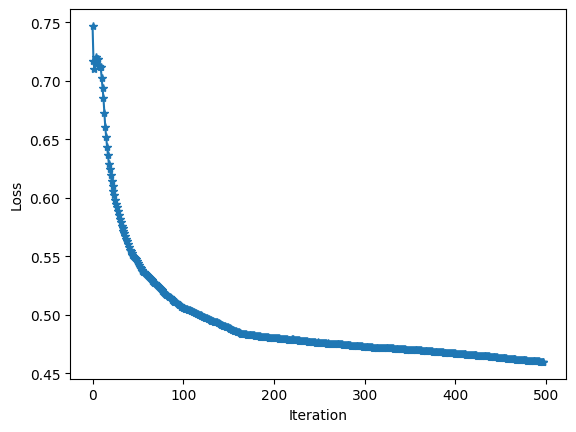




CPU times: user 13min 52s, sys: 16.7 s, total: 14min 9s
Wall time: 14min 22s


array([0.        , 0.74692577, 0.7165547 , 0.71008086, 0.71623766,
       0.7202248 , 0.7189948 , 0.71869332, 0.71278018, 0.71218151,
       0.71151245, 0.70253557, 0.6939258 , 0.68514264, 0.6722005 ,
       0.66051877, 0.65199274, 0.64358264, 0.63624293, 0.62882322,
       0.62485325, 0.61957133, 0.61472172, 0.61005241, 0.60613692,
       0.60254931, 0.59803593, 0.59507573, 0.59182519, 0.5885815 ,
       0.58515447, 0.58237159, 0.57931513, 0.57611895, 0.57415599,
       0.57170606, 0.56983322, 0.56727499, 0.56523269, 0.56295139,
       0.56069946, 0.55838436, 0.55576748, 0.55451465, 0.55254167,
       0.5513894 , 0.55016541, 0.54958075, 0.54834771, 0.54789162,
       0.54593593, 0.54416239, 0.54227859, 0.54060799, 0.53976381,
       0.53862232, 0.53780907, 0.53709412, 0.53676128, 0.53577983,
       0.53519738, 0.53423971, 0.53342104, 0.53263134, 0.5316689 ,
       0.53063911, 0.52989155, 0.529037  , 0.52802056, 0.52761179,
       0.52707207, 0.52630031, 0.52546817, 0.52462602, 0.52388

In [ ]:
%%time
train_setup(net, lr=0.001, n_batches=250, batch_size = 64, display_freq=10, device = device_gpu)

In [ ]:
new_net = GRU_EncDec(len(eng_alpha2idx), 256, len(indic_alpha2idx), verbose=True)
new_net.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [ ]:
def infer(net, word,max_output_chars, device='cpu'):
    net.eval().to(device)
    word_ohe = eng_rep(word, eng_alpha2idx)
    output = net(word_ohe, max_output_chars)
    return output

In [ ]:
def get_indic_pred_word(net, eng_word, k = 1, device = 'cpu'):
    net = net.eval().to(device)
    outputs = infer(net, eng_word, 30, device)
    # print(outputs)
    indic_output = ''
    for index, out in enumerate(outputs):
      # print(index)
      val, indices = out.topk(k)
      # print(val)
      index = indices.tolist()[0][0]
      print(index)
      if index == 0:
          break
      indic_char = indic_alpha[index+1]
      print(indic_char)
      indic_output += indic_char
    # print(eng_word + ' - ' + indic_output)
    return indic_output

In [ ]:
get_indic_pred_word(new_net, eng_word='oncholke', k=1)

22
গ
72
৉
51
঴
63
ী
51
঴
72
৉
0


'গ\u09c9\u09b4ী\u09b4\u09c9'

In [ ]:
def calc_accuracy(net, device = 'cpu', data = data_val, k = 1):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    for i in range(len(data)):
        eng_word, indic_word = data[i]
        gt = gt_rep(indic_word, indic_alpha2idx, device)
        outputs = infer(net, eng_word, gt.shape[0], device)
        correct = 0
        for index, out in enumerate(outputs):
            val, indices = out.topk(k)
            # print(indices)
            
            indic_pos = indices.tolist()[0]
            # print(indic_pos)
            # print('stop')
            # break
            # print(indic_pos, gt[index])
            if indic_pos[0] == gt[index][0]:
              # print('here',indic_pos, gt[index][0])
            # if gt[index][0] in indic_pos:
              print(f'{eng_word}-{indic_word}')
              correct += 1
            # elif indic_pos[1] == gt[index][0]:
            #   indic_word_pred = get_indic_pred_word(net, eng_word, k)
            #   print(f'2nd: {eng_word}-{indic_word} - {indic_word_pred}')
            #   # break
        
        accuracy += correct/gt.shape[0]
    accuracy /= len(data)
    return accuracy

In [ ]:
accuracy_val = calc_accuracy(new_net, data=data_val, k = 1) * 100
print('Validation Accuracy w/o attention ', accuracy_val)


taxikeo-ট্যাক্সিকেও
taxikeo-ট্যাক্সিকেও
granada-গ্র্যানাডা
granada-গ্র্যানাডা
granada-গ্র্যানাডা
durtomo-দূরতম
mandope-মন্ডপে
mandope-মন্ডপে
mandope-মন্ডপে
ovarview-ওভারভিউ
freekeh-ফ্রিকেহ
freekeh-ফ্রিকেহ
freekeh-ফ্রিকেহ
miley-মিলে
miley-মিলে
nationalser-ন্যাশনালসের
nationalser-ন্যাশনালসের
seekkhokbrindo-শিক্ষকবৃন্দ
akkheperi-আক্ষেপেরই
akkheperi-আক্ষেপেরই
teemothy-টিমোথি
bhalobaas-ভালোবাসা
bhalobaas-ভালোবাসা
bhalobaas-ভালোবাসা
bhalobaas-ভালোবাসা
osthisondhi-অস্থিসন্ধি
osthisondhi-অস্থিসন্ধি
graambaaseeo-গ্রামবাসীও
graambaaseeo-গ্রামবাসীও
graambaaseeo-গ্রামবাসীও
graambaaseeo-গ্রামবাসীও
trutimatra-ত্রুটিমাত্র
trutimatra-ত্রুটিমাত্র
trutimatra-ত্রুটিমাত্র
sarjur-সরযূর
sarjur-সরযূর
tiuning-টিউনিং
tiuning-টিউনিং
kloud-ক্লাউড
kloud-ক্লাউড
korimpur-করিমপুর
purohitra-পুরোহিতরা
purohitra-পুরোহিতরা
purohitra-পুরোহিতরা
dighol-দীঘল
torkarite-তরকারিতে
torkarite-তরকারিতে
jarmaniteo-জার্মানিতেও
jarmaniteo-জার্মানিতেও
jarmaniteo-জার্মানিতেও
jarmaniteo-জার্মানিতেও
prachando-প্রচণ্ড
prachando-প্রচণ্ড
pr

KeyboardInterrupt: ignored

In [ ]:
%%time
# new_net = GRU_EncDec(len(eng_alpha2idx), 256, len(indic_alpha2idx), verbose=True)
# new_net.load_state_dict(torch.load("model.pth"))
accuracy_train = calc_accuracy(new_net, data=data_train) * 100
print('Train Accuracy w/o attention ', accuracy_train)
accuracy_val = calc_accuracy(new_net, data=data_val) * 100

# accuracy_attn = calc_accuracy(net_att) * 100
print('Test Accuracy w/o attention ', accuracy_test)
# print('Acurracy with attention', accuracy_attn)

Train Accuracy w/o attention  26.57850043235203
Validation Accuracy w/o attention  26.97148974405045
Test Accuracy w/o attention  26.70647165433662
CPU times: user 6min 27s, sys: 1.01 s, total: 6min 28s
Wall time: 6min 49s
